Steps - 
1. Import datasets
2. Create Pytorch dataset - which can load comments from the dataset, tokenize them using huggingface 
3. Pytorch data module to create training and validation data loaders
4. Create model by fine tuning pretrained roberta model and initialize classification head (helps classify each label in data corpus).
5. Train the model and evaluate its performance. 

Steps 2,4,5 require pytorch and hugging face

Steps 3,4,5 require pytorch lightning framework

In [0]:
pip install transformers pytorch-lightning sentencepiece mlflow

Python interpreter will be restarted.
  Using cached transformers-4.33.0-py3-none-any.whl (7.6 MB)
  Using cached pytorch_lightning-2.0.8-py3-none-any.whl (727 kB)
  Using cached sentencepiece-0.1.99-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.3 MB)
  Using cached mlflow-2.6.0-py3-none-any.whl (18.3 MB)
  Using cached PyYAML-6.0.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (738 kB)
  Using cached safetensors-0.3.3-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.3 MB)
  Using cached regex-2023.8.8-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (771 kB)
  Using cached huggingface_hub-0.16.4-py3-none-any.whl (268 kB)
  Using cached tokenizers-0.13.3-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (7.8 MB)
  Using cached tqdm-4.66.1-py3-none-any.whl (78 kB)
  Using cached torch-2.0.1-cp39-cp39-manylinux1_x86_64.whl (619.9 MB)
  Using cached fsspec-2023.9.0-py3-none-any.whl (173 kB)
  Using cached lightning_utilities-0.9.0-py3-non

In [0]:
#import the data
import pandas as pd

In [0]:
train_path = '/dbfs/FileStore/tables/train_df.csv'
val_path = '/dbfs/FileStore/tables/val_df.csv'
test_path = '/dbfs/FileStore/tables/test_df.csv'

train_data = pd.read_csv(train_path)
val_data = pd.read_csv(val_path)
test_data = pd.read_csv(test_path)

In [0]:
print(len(train_data))
print(len(val_data))
print(len(test_data))

31232
5205
5206


In [0]:
# Shuffle the data to ensure randomness
train_data = train_data.sample(frac=1, random_state=42).reset_index(drop=True)
val_data = val_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Select 500 samples for each sentiment in the training data
train_data = train_data.groupby('sentiment', group_keys=False).apply(lambda x: x.sample(500, random_state=42)).reset_index(drop=True)

# Select 500 samples for each sentiment in the validation data
val_data = val_data.groupby('sentiment', group_keys=False).apply(lambda x: x.sample(500, random_state=42)).reset_index(drop=True)

train_data = pd.get_dummies(train_data, columns=['sentiment'], prefix='', prefix_sep='')
val_data = pd.get_dummies(val_data, columns=['sentiment'], prefix='', prefix_sep='')

# Save the modified datasets back to CSV files
train_data.to_csv('/dbfs/FileStore/tables/train_df_filtered.csv', index=False)
val_data.to_csv('/dbfs/FileStore/tables/val_df_filtered.csv', index=False)

# Verify the length of the filtered datasets
print(len(train_data))
print(len(val_data))

1500
1500


In [0]:
train_data

,id,text,label,negative,neutral,positive
0,4181,Why are you counting inactive habits for the 5...,0,1,0,0
1,19956,nope no love,0,1,0,0
2,22049,ugh. trying to respond to all of the emails/vo...,0,1,0,0
3,15944,Twitter is useful in that it reminds people wh...,0,1,0,0
4,8408,that makes me sad for you,0,1,0,0
...,...,...,...,...,...,...
1495,5974,morning darlin` Hope you`re feelin` tip-top ...,2,0,0,1
1496,10104,Allow notes and tasks sync to Google drive wit...,2,0,0,1
1497,18073,"unhooking my pt`s, then home to SLEEP! SLEEP I...",2,0,0,1
1498,1782,looking forward to coffee and driving tomorrow...,2,0,0,1


In [0]:
# Replace the original data file paths with the filtered data file paths
train_path = '/dbfs/FileStore/tables/train_df_filtered.csv'
val_path = '/dbfs/FileStore/tables/val_df_filtered.csv'
#test_path = '/dbfs/FileStore/tables/test_data.csv'

In [0]:
#train_data.to_csv(train_path, index=False)  
#val_data.to_csv(val_path, index=False)
#test_data.to_csv(test_path, index=False)

In [0]:
#inspect the data 
import matplotlib.pyplot as plt
import seaborn as sns

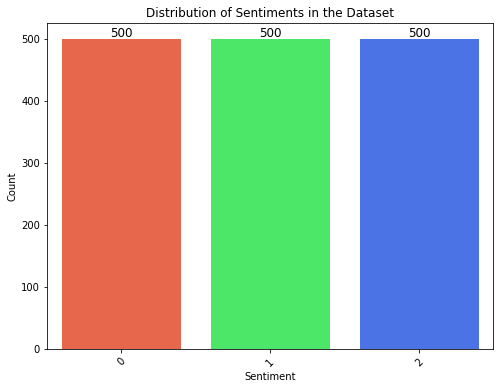

In [0]:
custom_palette = ["#FF5733", "#33FF57", "#3366FF"] 
sentiment_counts = train_data['label'].value_counts()

# Plot sentiment distribution
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=custom_palette)
plt.title('Distribution of Sentiments in the Dataset')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Display count to check for class balancing
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

plt.show()

In [0]:
#pytorch dataset

from torch.utils.data import Dataset
import torch
from transformers import AutoTokenizer

In [0]:
attributes = ['negative','neutral','positive']

In [0]:
class Senti_Dataset(Dataset):

  def __init__(self, data_path, tokenizer, attributes, max_token_len: int = 128):
    self.data_path = data_path
    self.tokenizer = tokenizer
    self.attributes = attributes
    self.max_token_len = max_token_len
    self._prepare_data() #sets up the data in the format we want


  def _prepare_data(self):
    data = pd.read_csv(self.data_path)
    self.data = data
    #any data prep/class balancing falls here (use if/else for train and val)
    
  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    item = self.data.iloc[index]
    comment = str(item.text)
    attributes = torch.FloatTensor(item[self.attributes])
    tokens = self.tokenizer.encode_plus(comment,
                                        add_special_tokens=True,
                                        return_tensors='pt',
                                        truncation=True,
                                        padding='max_length',
                                        max_length=self.max_token_len,
                                        return_attention_mask = True)
    return {'input_ids': tokens.input_ids.flatten(), 'attention_mask': tokens.attention_mask.flatten(),'labels': attributes}




In [0]:
#model_name = 'cardiffnlp/twitter-xlm-roberta-base-sentiment'
model_name = 'roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
senti_ds = Senti_Dataset(train_path, tokenizer, attributes=attributes) #train dataset
senti_ds_val = Senti_Dataset(val_path, tokenizer, attributes=attributes) #validation dataset

In [0]:
senti_ds.__getitem__(0)['labels'].shape, senti_ds.__getitem__(0)['input_ids'].shape, senti_ds.__getitem__(0)['attention_mask'].shape

Out[14]: (torch.Size([3]), torch.Size([128]), torch.Size([128]))

In [0]:
len(senti_ds)

Out[15]: 1500

In [0]:
len(senti_ds_val)

Out[16]: 1500

In [0]:
#Data module 

import pytorch_lightning as pl
from torch.utils.data import DataLoader

In [0]:
class Senti_Data_Module(pl.LightningDataModule):
    def __init__(self, train_path, val_path, test_path, attributes, batch_size=16, max_token_length=128,
                 model_name='roberta-base'):
        super().__init__()
        self.train_path = train_path
        self.val_path = val_path
        self.test_path = test_path
        self.attributes = attributes
        self.batch_size = batch_size
        self.max_token_length = max_token_length
        self.model_name = model_name
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

    def setup(self, stage = None):
        if stage in (None, "fit"):
            self.train_dataset = Senti_Dataset(self.train_path, attributes=self.attributes, tokenizer=self.tokenizer)
            self.val_dataset = Senti_Dataset(self.val_path, attributes=self.attributes, tokenizer=self.tokenizer)
        if stage == 'predict':
            self.text_dataset = Senti_Dataset(self.text_path, attributes=self.attributes, tokenizer=self.tokenizer)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=4, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size = self.batch_size, num_workers=4, shuffle=False)

    def predict_dataloader(self):
        return DataLoader(self.test_dataset, batch_size = self.batch_size, num_workers=4, shuffle=False)


In [0]:
senti_data_module = Senti_Data_Module(train_path, val_path, test_path, attributes=attributes)

In [0]:
senti_data_module.setup()

In [0]:
senti_data_module.train_dataloader()

Out[21]: <torch.utils.data.dataloader.DataLoader at 0x7fcbb6d72790>

In [0]:
len(senti_data_module.train_dataloader()) #Number of batches in training dataset

Out[22]: 94

In [0]:
#Create model

from transformers import AutoModel, AdamW, get_cosine_schedule_with_warmup
import torch.nn as nn
import math
from torchmetrics.functional.classification import auroc
import torch.nn.functional as F

In [0]:
class Senti_Comment_Classifier(pl.LightningModule):

  def __init__(self, config: dict):
    super().__init__()
    self.config = config
    self.pretrained_model = AutoModel.from_pretrained(config['model_name'], return_dict = True)
    self.hidden = torch.nn.Linear(self.pretrained_model.config.hidden_size, self.pretrained_model.config.hidden_size)
    self.classifier = torch.nn.Linear(self.pretrained_model.config.hidden_size, self.config['n_labels'])
    torch.nn.init.xavier_uniform_(self.classifier.weight)
    self.loss_func = nn.BCEWithLogitsLoss(reduction='mean')
    self.dropout = nn.Dropout()
    
  def forward(self, input_ids, attention_mask, labels=None):
    # roberta layer
    output = self.pretrained_model(input_ids=input_ids, attention_mask=attention_mask)
    pooled_output = torch.mean(output.last_hidden_state, 1)
    # final logits
    pooled_output = self.dropout(pooled_output)
    pooled_output = self.hidden(pooled_output)
    pooled_output = F.relu(pooled_output)
    pooled_output = self.dropout(pooled_output)
    logits = self.classifier(pooled_output)
    # calculate loss
    loss = 0
    if labels is not None:
      loss = self.loss_func(logits.view(-1, self.config['n_labels']), labels.view(-1, self.config['n_labels']))
    return loss, logits

  def training_step(self, batch, batch_index):
    loss, outputs = self(**batch)
    self.log("train loss ", loss, prog_bar = True, logger=True)
    return {"loss":loss, "predictions":outputs, "labels": batch["labels"]}

  def validation_step(self, batch, batch_index):
    loss, outputs = self(**batch)
    self.log("validation loss ", loss, prog_bar = True, logger=True)
    return {"val_loss": loss, "predictions":outputs, "labels": batch["labels"]}

  def predict_step(self, batch, batch_index):
    loss, outputs = self(**batch)
    return outputs

  def configure_optimizers(self):
    optimizer = AdamW(self.parameters(), lr=self.config['lr'], weight_decay=self.config['weight_decay'])
    total_steps = self.config['train_size']/self.config['batch_size']
    warmup_steps = math.floor(total_steps * self.config['warmup'])
    warmup_steps = math.floor(total_steps * self.config['warmup'])
    scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)
    return [optimizer],[scheduler]

In [0]:
config = {
    'model_name': 'roberta-base',
    'n_labels': len(attributes),
    'log_every_n_steps': 5,
    'batch_size': 128,
    'lr': 1.5e-6,
    'warmup': 0.2, 
    'train_size': len(senti_data_module.train_dataloader()),
    'weight_decay': 0.001,
    'n_epochs': 6
}

model = Senti_Comment_Classifier(config)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [0]:
idx=0
input_ids = senti_ds.__getitem__(idx)['input_ids']
attention_mask = senti_ds.__getitem__(idx)['attention_mask']
labels = senti_ds.__getitem__(idx)['labels']
model.cpu()
loss, output = model(input_ids.unsqueeze(dim=0), attention_mask.unsqueeze(dim=0), labels.unsqueeze(dim=0))
print(labels.shape, output.shape, output)

torch.Size([3]) torch.Size([1, 3]) tensor([[ 0.6793, -0.7744,  0.3417]], grad_fn=<AddmmBackward0>)


In [0]:
#train model

In [0]:
import mlflow
import mlflow.pytorch
import pytorch_lightning as pl

import mlflow
from pytorch_lightning.loggers import MLFlowLogger

In [0]:
mlflow.end_run()

In [0]:
# MLflow setup
experiment_name = "/Users/mohamed.zahid@simpleenergy.in/comment_class"  # Replace with a descriptive experiment name
mlflow_logger = MLFlowLogger(experiment_name=experiment_name)

# Start an MLflow run
with mlflow.start_run():
    # Log parameters to the run
    mlflow.log_params(config)

    # Data Module setup
    senti_data_module = Senti_Data_Module(train_path, val_path, test_path, attributes=attributes,
                                          batch_size=config['batch_size'])
    senti_data_module.setup()

    # Model
    model = Senti_Comment_Classifier(config)

    # Trainer setup
    trainer = pl.Trainer(max_epochs=config['n_epochs'], num_sanity_val_steps=50, logger=mlflow_logger)

    # Train the model
    trainer.fit(model, senti_data_module)

    # Save the PyTorch Lightning model checkpoint to a local directory
    checkpoint_path = "/dbfs/FileStore/model_checkpoint.pt"  # Adjust the path accordingly
    trainer.save_checkpoint(checkpoint_path)

    # Log the PyTorch Lightning model checkpoint as an artifact
    mlflow.pytorch.log_model(model, artifact_path="dbfs:/FileStore")

    # # Replace 'local_dir_with_artifacts' with the actual path to your additional artifacts
    # additional_artifacts_path = "dbfs:/databricks/mlflow-tracking/3432650433248683"  # Adjust this path
    # Log additional artifacts such as plots or files
    # mlflow.log_artifacts(additional_artifacts_path, artifact_path="extras")


---------------------------------------------------------------------------
The Python process exited with exit code 137 (SIGKILL: Killed). This may have been caused by an OOM error. Check your command's memory usage.

---------------------------------------------------------------------------
The last 10 KB of the process's stderr and stdout can be found below. See driver logs for full logs.
---------------------------------------------------------------------------
Last messages on stderr:
Wed Sep  6 06:54:11 2023 Connection to spark from PID  9618
Wed Sep  6 06:54:11 2023 Initialized gateway on port 36263
Wed Sep  6 06:54:12 2023 Connected to spark.
2023-09-06 06:54:30.429075: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-06 06:54:32.727962:

In [0]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs/

Your log directory might be ephemeral to the cluster, which will be deleted after cluster termination or restart. You can choose a log directory under `/dbfs/` to persist your logs in DBFS.


ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2023-09-05 22:58:53.421294: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-05 22:58:53.528196: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-05 22:58:53.529083: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-05 22:58:55.117219: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/databricks/python/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >=

In [0]:
#############################################################################################################################################################################################################################

In [0]:
import numpy as np

In [0]:
# method to convert list of comments into predictions for each comment
def classify_raw_comments(model, dm):
  predictions = trainer.predict(model, datamodule=dm)
  flattened_predictions = np.stack([torch.sigmoid(torch.Tensor(p)) for batch in predictions for p in batch])
  return flattened_predictions


In [0]:
predictions = classify_raw_comments(model, senti_data_module)

In [0]:
predictions

Out[72]: array([[0.42850676, 0.5624248 , 0.36501125],
       [0.5471387 , 0.59594756, 0.3399927 ],
       [0.47456315, 0.5686338 , 0.33838224],
       ...,
       [0.4818082 , 0.50572973, 0.50862354],
       [0.4171232 , 0.6611567 , 0.6007816 ],
       [0.5139573 , 0.54961956, 0.47696117]], dtype=float32)

In [0]:

# Map predictions
attributes = ['negative', 'neutral', 'positive']
max_indices = [(pred.argmax(), attributes[pred.argmax()], pred.max()) for pred in predictions]

df = pd.DataFrame(max_indices, columns=['label', 'sentiment', 'sentiment_score'])

# DF
df

,label,sentiment,sentiment_score
0,1,neutral,0.562425
1,1,neutral,0.595948
2,1,neutral,0.568634
3,0,negative,0.525212
4,0,negative,0.573754
...,...,...,...
1495,0,negative,0.555860
1496,0,negative,0.558882
1497,2,positive,0.508624
1498,1,neutral,0.661157


In [0]:
true_labels = np.array(test_data[attributes]) 

Out[43]: Text(0.5, 1.0, 'RoBERTa Trained on Datatset - AUC ROC')

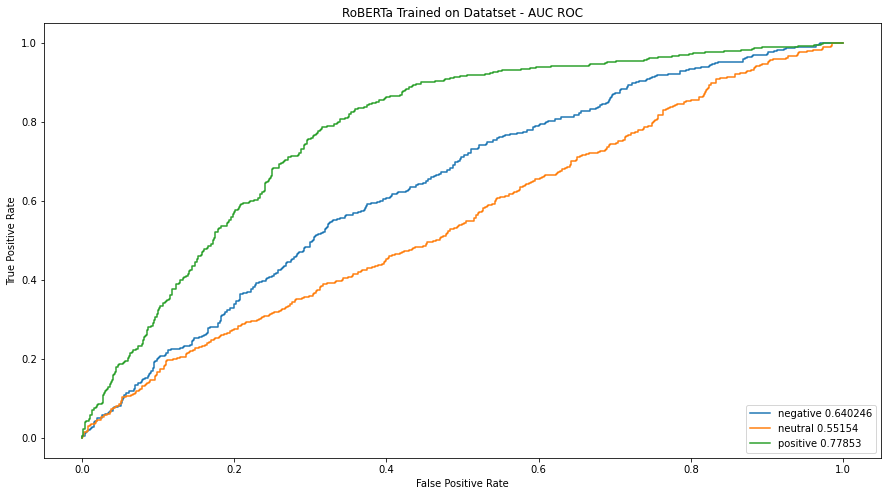

In [0]:
from sklearn import metrics
plt.figure(figsize=(15, 8))
for i, attribute in enumerate(attributes):
  fpr, tpr, _ = metrics.roc_curve(
      true_labels[:,i].astype(int), predictions[:, i])
  auc = metrics.roc_auc_score(
      true_labels[:,i].astype(int), predictions[:, i])
  plt.plot(fpr, tpr, label='%s %g' % (attribute, auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('RoBERTa Trained on Datatset - AUC ROC')